## Dataset Preparation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import nltk
import re
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import LabelEncoder

In [2]:
train_df = pd.read_json("./data/bias_articles_train.json")
dev_df = pd.read_json("./data/bias_articles_dev.json")
test_df = pd.read_json("./data/bias_articles_test.json")

In [3]:
def drop_nan(df):
    if df.isnull().values.any() == True:
        return df.dropna().reset_index()

# drop id=175 (all values are NaN)
train_df = drop_nan(train_df)

In [4]:
def df_concat(df1, df2):
    return pd.concat([df1, df2])

full_df = df_concat(train_df, dev_df)

<AxesSubplot:xlabel='bias', ylabel='count'>

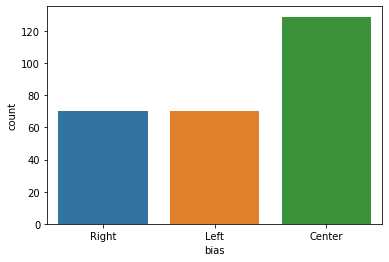

In [5]:
def data_distribution(df):
    return sns.countplot(x='bias', data=df)

# "Center" class proportion is almost 2:1 compared to the others.
data_distribution(full_df)

In [6]:
def data_cleaning(text):
    # Remove symbols and punctuations & apply loxer() to string
    formatted_text = re.sub(r"[^\w\s]", " ", text).lower()

    # Remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    words = [i for i in formatted_text.split() if not i in stopwords]
    
    # Stemming tokens
    word_stem = [PorterStemmer().stem(word) for word in words]
    
    return (" ".join(word_stem))

def column_concat(df, col1, col2):
    return (df[col1] + ' ' + df[col2])
    
train_df['title_body'] = [data_cleaning(i) for i in column_concat(train_df, 'title', 'body')]
dev_df['title_body'] = [data_cleaning(i) for i in column_concat(dev_df, 'title', 'body')]
full_df['title_body'] = [data_cleaning(i) for i in column_concat(full_df, 'title', 'body')]

In [7]:
train_x, dev_x, full_x = train_df['title_body'], dev_df['title_body'], full_df['title_body']
train_y, dev_y = LabelEncoder().fit_transform(train_df['bias']), LabelEncoder().fit_transform(dev_df['bias'])

## Feature Engineering

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#### CountVectorizer

In [9]:
# create a count vectorizer object 
count_vect = CountVectorizer()
count_vect.fit(full_x)

# transform the training data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xdev_count =  count_vect.transform(dev_x)

#### TF-IDF

In [11]:
# word level tf-idf
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(full_x)
xtrain_tfidf =  tfidf_vect.transform(train_x)
xdev_tfidf =  tfidf_vect.transform(dev_x)

# ngram level tf-idf 
tfidf_vect_ngram = TfidfVectorizer(ngram_range=(2,4))
tfidf_vect_ngram.fit(full_x)
xtrain_tfidf_ngram =  tfidf_vect_ngram.transform(train_x)
xdev_tfidf_ngram =  tfidf_vect_ngram.transform(dev_x)

#### Word Embeddings

In [12]:
# # load the whole embedding into memory
# embeddings_index = dict()
# f = open('data/glove/glove.6B.100d.txt')

# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs

# f.close()
# print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [13]:
# # Tokenize the sentences
# tokenizer = Tokenizer()

# # Preparing vocabulary
# tokenizer.fit_on_texts(list(full_x))

# # Converting text into integer sequences and padding to prepare sequences of same length
# train_x_seq  = pad_sequences(tokenizer.texts_to_sequences(train_x), maxlen=512)
# dev_x_seq = pad_sequences(tokenizer.texts_to_sequences(dev_x), maxlen=512)

In [14]:
# size_of_vocabulary=len(tokenizer.word_index) + 1 #+1 for padding
# print(size_of_vocabulary)

7449


In [15]:
# # Create a weight matrix for words in training docs
# embedding_matrix = np.zeros((size_of_vocabulary, 100))

# for word, i in tokenizer.word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector

## Model Training

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [17]:
def train_model(classifier, feature_vector_train, label_train, feature_vector_dev, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label_train)
    
    # predict the labels on dev dataset
    predictions = classifier.predict(feature_vector_dev)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return classifier, predictions

#### Naive Bayes

In [18]:
# Naive Bayes on Count Vectors
nbCV_pipeline = Pipeline([
        ('nbCV', count_vect),
        ('nb_clf', MultinomialNB())])

nbCV_model, nbCV_pred = train_model(nbCV_pipeline, train_x, train_y, dev_x)
print(classification_report(nbCV_pred, dev_y))

              precision    recall  f1-score   support

           0       0.40      0.40      0.40        15
           1       0.12      0.17      0.14         6
           2       0.00      0.00      0.00         9

    accuracy                           0.23        30
   macro avg       0.18      0.19      0.18        30
weighted avg       0.23      0.23      0.23        30



In [19]:
# Naive Bayes on Word Level TF-IDF Vectors
nbTFIDF_pipeline = Pipeline([
        ('nbTFIDF', tfidf_vect),
        ('nb_clf', MultinomialNB())])

nbTFIDF_model, nbTFIDF_pred = train_model(nbTFIDF_pipeline, train_x, train_y, dev_x)
print(classification_report(nbTFIDF_pred, dev_y))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        30
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.50        30
   macro avg       0.33      0.17      0.22        30
weighted avg       1.00      0.50      0.67        30



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Naive Bayes on Ngram Level TF IDF Vectors
nbTFIDF_ngram_pipeline = Pipeline([
        ('nbTFIDFngram', tfidf_vect_ngram),
        ('nb_clf', MultinomialNB())])

nbTFIDF_ngram_model, nbTFIDF_ngram_pred = train_model(nbTFIDF_ngram_pipeline, train_x, train_y, dev_x)
print(classification_report(nbTFIDF_ngram_pred, dev_y))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        30
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.50        30
   macro avg       0.33      0.17      0.22        30
weighted avg       1.00      0.50      0.67        30



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### SVM

In [40]:
# SVM on Count Vectors
svmCV_pipeline = Pipeline([
        ('svmCV', count_vect),
        ('svmclf', SVC(class_weight='balanced'))])

svmCV_model, svmCV_pred = train_model(svmCV_pipeline, train_x, train_y, dev_x)
print(classification_report(svmCV_pred, dev_y))

              precision    recall  f1-score   support

           0       0.47      0.50      0.48        14
           1       0.00      0.00      0.00         3
           2       0.43      0.23      0.30        13

    accuracy                           0.33        30
   macro avg       0.30      0.24      0.26        30
weighted avg       0.40      0.33      0.36        30



In [22]:
# SVM on Word Level TF IDF Vectors
svmTFIDF_pipeline = Pipeline([
        ('svmTFIDF', tfidf_vect),
        ('svmclf', SVC(class_weight='balanced'))])

svmTFIDF_model, svmTFIDF_pred = train_model(svmTFIDF_pipeline, train_x, train_y, dev_x)
print(classification_report(svmTFIDF_pred, dev_y))

              precision    recall  f1-score   support

           0       0.33      0.38      0.36        13
           1       0.25      0.22      0.24         9
           2       0.00      0.00      0.00         8

    accuracy                           0.23        30
   macro avg       0.19      0.20      0.20        30
weighted avg       0.22      0.23      0.23        30



In [23]:
# SVM on Ngram Level TF IDF Vectors
svmTFIDF_ngram_pipeline = Pipeline([
        ('svmTFIDFngram', tfidf_vect_ngram),
        ('svmclf', SVC(class_weight='balanced'))])

svmTFIDF_ngram_model, svmTFIDF_ngram_pred = train_model(svmTFIDF_ngram_pipeline, train_x, train_y, dev_x)
print(classification_report(svmTFIDF_ngram_pred, dev_y))

              precision    recall  f1-score   support

           0       0.67      0.43      0.53        23
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         4

    accuracy                           0.33        30
   macro avg       0.22      0.14      0.18        30
weighted avg       0.51      0.33      0.40        30



#### Random Forest

In [24]:
# Random Forest on Count Vectors
rfCV_pipeline = Pipeline([
        ('rfCV', count_vect),
        ('rfclf', RandomForestClassifier(class_weight='balanced'))])

rfCV_model, rfCV_pred = train_model(rfCV_pipeline, train_x, train_y, dev_x)
print(classification_report(rfCV_pred, dev_y))

              precision    recall  f1-score   support

           0       0.87      0.48      0.62        27
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2

    accuracy                           0.43        30
   macro avg       0.29      0.16      0.21        30
weighted avg       0.78      0.43      0.56        30



In [25]:
# Random Forest on Word Level TF IDF Vectors
rfTFIDF_pipeline = Pipeline([
        ('rfTFIDF', tfidf_vect),
        ('rfclf', RandomForestClassifier(class_weight='balanced'))])

rfTFIDF_model, rfTFIDF_pred = train_model(rfTFIDF_pipeline, train_x, train_y, dev_x)
print(classification_report(rfTFIDF_pred, dev_y))

              precision    recall  f1-score   support

           0       0.73      0.46      0.56        24
           1       0.00      0.00      0.00         1
           2       0.14      0.20      0.17         5

    accuracy                           0.40        30
   macro avg       0.29      0.22      0.24        30
weighted avg       0.61      0.40      0.48        30



In [26]:
# Random Forest on Ngram Level TF IDF Vectors
rfTFIDF_ngram_pipeline = Pipeline([
        ('rfTFIDFngram', tfidf_vect_ngram),
        ('rfclf', RandomForestClassifier(class_weight='balanced'))])

rfTFIDF_ngram_model, rfTFIDF_ngram_pred = train_model(rfTFIDF_ngram_pipeline, train_x, train_y, dev_x)
print(classification_report(rfTFIDF_ngram_pred, dev_y))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67        30
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0

    accuracy                           0.50        30
   macro avg       0.33      0.17      0.22        30
weighted avg       1.00      0.50      0.67        30



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Fine-tuning

In [27]:
from sklearn.model_selection import GridSearchCV

#### Naive Bayes

In [55]:
# Naive Bayes on Count Vectors
parameters = {'nbCV__max_df': (0.25, 0.5, 0.75, 1.0),
              'nbCV__analyzer': ['word', 'char']}

gs_nbCV = GridSearchCV(nbCV_model, parameters, n_jobs=-1)
gs_nbCV = gs_nbCV.fit(train_x, train_y)

gs_nbCV.best_params_

{'nbCV__analyzer': 'char', 'nbCV__max_df': 0.25}

In [57]:
gs_nbCV.best_score_

0.46028368794326247

In [59]:
# Naive Bayes on Word Level TF-IDF Vectors
parameters = {'nbTFIDF__use_idf': (True, False),}

gs_nbTFIDF = GridSearchCV(nbTFIDF_model, parameters, n_jobs=-1)
gs_nbTFIDF = gs_nbTFIDF.fit(train_x, train_y)

gs_nbTFIDF.best_params_

{'nbTFIDF__use_idf': True}

In [60]:
gs_nbTFIDF.best_score_

0.4769503546099291

In [64]:
# Naive Bayes on Ngram Level TF IDF Vectors
parameters = {'nbTFIDFngram__use_idf': (True, False),
              'nbTFIDFngram__ngram_range': [(1, 3), (2, 3), (1, 4)]}

gs_nbTFIDFngram = GridSearchCV(nbTFIDF_ngram_model, parameters, n_jobs=-1)
gs_nbTFIDFngram = gs_nbTFIDFngram.fit(train_x, train_y)

gs_nbTFIDFngram.best_params_

{'nbTFIDFngram__ngram_range': (1, 3), 'nbTFIDFngram__use_idf': True}

In [65]:
gs_nbTFIDFngram.best_score_

0.4769503546099291

#### SVM

In [46]:
# SVM on Count Vectors
parameters = {'svmCV__max_df': (0.25, 0.5, 0.75, 1.0),
              'svmCV__analyzer': ['word', 'char'],
              'svmclf__C': [1.0, 1.2, 2, 0.8],
              'svmclf__class_weight': [None, 'balanced'],
              'svmclf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'svmclf__degree': [3, 4],
              'svmclf__gamma': ['auto', 'scale']
}

gs_svmCV = GridSearchCV(svmCV_model, parameters, n_jobs=-1)
gs_svmCV = gs_svmCV.fit(train_x, train_y)

gs_svmCV.best_params_

{'svmCV__analyzer': 'char',
 'svmCV__max_df': 0.75,
 'svmclf__C': 2,
 'svmclf__class_weight': None,
 'svmclf__degree': 3,
 'svmclf__gamma': 'scale',
 'svmclf__kernel': 'poly'}

In [47]:
gs_svmCV.best_score_

0.4854609929078014

In [48]:
# SVM on Word Level TF IDF Vectors
parameters = {'svmTFIDF__use_idf': (True, False),
              'svmclf__C': [0.1,1, 10, 100],
              'svmclf__class_weight': [None, 'balanced'],
              'svmclf__kernel': ['poly', 'rbf', 'sigmoid'],
              'svmclf__degree': [3, 4]
}

gs_svmTFIDF = GridSearchCV(svmTFIDF_model, parameters, n_jobs=-1)
gs_svmTFIDF = gs_svmTFIDF.fit(train_x, train_y)

gs_svmTFIDF.best_params_

{'svmTFIDF__use_idf': True,
 'svmclf__C': 0.1,
 'svmclf__class_weight': None,
 'svmclf__degree': 3,
 'svmclf__kernel': 'poly'}

In [49]:
gs_svmTFIDF.best_score_

0.4769503546099291

In [51]:
# SVM on Ngram Level TF IDF Vectors
parameters = {'svmTFIDFngram__ngram_range': [(1, 3), (2, 3), (1, 4)],
              'svmTFIDFngram__use_idf': (True, False),
              'svmclf__C': [0.1,1, 10, 100],
              'svmclf__class_weight': [None, 'balanced'],
              'svmclf__kernel': ['poly', 'rbf', 'sigmoid'],
              'svmclf__degree': [3, 4]
}

gs_svmTFIDFngram = GridSearchCV(svmTFIDF_ngram_model, parameters, n_jobs=-1)
gs_svmTFIDFngram = gs_svmTFIDFngram.fit(train_x, train_y)

gs_svmTFIDFngram.best_params_

{'svmTFIDFngram__ngram_range': (1, 3),
 'svmTFIDFngram__use_idf': True,
 'svmclf__C': 0.1,
 'svmclf__class_weight': None,
 'svmclf__degree': 3,
 'svmclf__kernel': 'poly'}

In [52]:
gs_svmTFIDFngram.best_score_

0.4769503546099291

#### Random Forest

In [30]:
# Random Forest on Count Vectors
parameters = {'rfCV__max_df': (0.25, 0.5, 0.75, 1.0),
              'rfCV__analyzer': ['word', 'char'],
              'rfclf__max_features': ['auto', 'sqrt'],
              'rfclf__max_depth': (2,4,6,8,10),
              'rfclf__class_weight': [None, 'balanced']
}

gs_rfCV = GridSearchCV(rfCV_model, parameters, n_jobs=-1)
gs_rfCV = gs_rfCV.fit(train_x, train_y)

gs_rfCV.best_params_

{'rfCV__analyzer': 'char',
 'rfCV__max_df': 0.75,
 'rfclf__class_weight': None,
 'rfclf__max_depth': 4,
 'rfclf__max_features': 'auto'}

In [34]:
gs_rfCV.best_score_

0.48962765957446813

In [31]:
# Random Forest on Word Level TF IDF Vectors
parameters = {'rfTFIDF__max_df': (0.25, 0.5, 0.75, 1.0),
              'rfTFIDF__analyzer': ['word', 'char'],
              'rfTFIDF__use_idf': (True, False),
              'rfclf__max_features': ['auto', 'sqrt'],
              'rfclf__class_weight': [None, 'balanced'],
              'rfclf__max_depth': (2,4,6,8,10)
}

gs_rfTFIDF = GridSearchCV(rfTFIDF_model, parameters, n_jobs=-1)
gs_rfTFIDF = gs_rfTFIDF.fit(train_x, train_y)

gs_rfTFIDF.best_params_

{'rfTFIDF__analyzer': 'word',
 'rfTFIDF__max_df': 0.5,
 'rfTFIDF__use_idf': False,
 'rfclf__class_weight': None,
 'rfclf__max_depth': 8,
 'rfclf__max_features': 'sqrt'}

In [35]:
gs_rfTFIDF.best_score_

0.4854609929078014

In [32]:
# Random Forest on Ngram Level TF IDF Vectors
parameters = {'rfTFIDFngram__ngram_range': [(1, 3), (2, 3), (2, 4), (3, 4), (1, 4)],
              'rfTFIDFngram__max_df': (0.25, 0.5, 0.75, 1.0),
              'rfTFIDFngram__analyzer': ['word', 'char'],
              'rfTFIDFngram__use_idf': (True, False),
              'rfclf__max_features': ['auto', 'sqrt'],
              'rfclf__class_weight': [None, 'balanced'],
              'rfclf__max_depth': (2,4,6,8,10)
}

gs_rfTFIDF_ngram = GridSearchCV(rfTFIDF_ngram_model, parameters, n_jobs=-1)
gs_rfTFIDF_ngram= gs_rfTFIDF_ngram.fit(train_x, train_y)

gs_rfTFIDF_ngram.best_params_

{'rfTFIDFngram__analyzer': 'word',
 'rfTFIDFngram__max_df': 0.25,
 'rfTFIDFngram__ngram_range': (2, 3),
 'rfTFIDFngram__use_idf': False,
 'rfclf__class_weight': 'balanced',
 'rfclf__max_depth': 6,
 'rfclf__max_features': 'sqrt'}

In [36]:
gs_rfTFIDF_ngram.best_score_

0.5105496453900709

## Test set predictions

In [107]:
test_x = test_df['title_body'] = [data_cleaning(i) for i in column_concat(test_df, 'title', 'body')]

In [110]:
# Random Forest on Ngram Level TF IDF Vectors
rfTFIDF_ngram_pipeline = Pipeline([
        ('rfTFIDFngram', TfidfVectorizer(max_df=0.25, ngram_range=(2, 3), use_idf=False)),
        ('rfclf', RandomForestClassifier(class_weight='balanced', max_depth=6, max_features='sqrt'))])

rfTFIDF_ngram_model, rfTFIDF_ngram_pred = train_model(rfTFIDF_ngram_pipeline, train_x, train_y, test_x)
# print(classification_report(rfTFIDF_ngram_pred, dev_y))

In [111]:
rfTFIDF_ngram_pred

array([0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0])

In [113]:
test_df['bias_predicted'] = rfTFIDF_ngram_pred

In [115]:
test_df["bias_predicted"].replace({0: "Center", 2: "Right", 1: "Left"}, inplace=True)

In [116]:
test_df

,body,id,title,title_body,bias_predicted
0,WASHINGTON -- The U.S. Attorney’s office in N...,270,U.S. Attorney Subpoenas Chris Christie Campaig...,u attorney subpoena chri christi campaign docu...,Center
1,"Roger Stone, an eccentric longtime Republican...",271,Trump Associate Roger Stone Indicted In Muelle...,trump associ roger stone indict mueller invest...,Center
2,"Democrats’ landmark campaign finance, voting ...",272,House Democrats Pass Landmark Campaign Finance...,hous democrat pass landmark campaign financ vo...,Right
3,WASHINGTON -- President Barack Obama on Frida...,273,"Obama Defends NSA Programs, Says Congress Knew...",obama defend nsa program say congress knew sur...,Center
4,WASHINGTON — The lawmakers trotted from their...,274,"Shooting Brings Rare Comity to the Capital, bu...",shoot bring rare comiti capit last washington ...,Center
5,"Susan Rice, President Barack Obama's national...",275,Susan Rice: Netanyahu Visit 'Destructive' To U...,susan rice netanyahu visit destruct u israel r...,Center
6,"WASHINGTON — The special counsel, Robert S. M...",276,"Indicting Roger Stone, Mueller Shows Link Betw...",indict roger stone mueller show link trump cam...,Left
7,"Mike Huckabee, a former Republican governor o...",277,Mike Huckabee on the Issues,mike huckabe issu mike huckabe former republic...,Center
8,WASHINGTON ― President Donald Trump’s offer t...,278,Trump's 'Compromise' Immigration Offer To Demo...,trump compromis immigr offer democrat includ m...,Center
9,The Obama administration found itself defendi...,279,Obama administration defends 2nd mass surveill...,obama administr defend 2nd mass surveil projec...,Center


In [117]:
test_df.to_csv('data/pred/bias_articles_test_pred.csv',
               columns=['bias_predicted', 'id', 'title', 'body'],
               index=False)